In [1]:
#----------------------------------------------------Flight Fare Prediction------------------------------------------------

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
df = pd.read_csv("C:/Users/91801/Desktop/Projects/Filght Fare/Flight fare data.csv")
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24-03-2019,Banglore,New Delhi,BLR → DEL,22:20,22-03-2025 01:10,2h 50m,non-stop,No info,3897
1,Air India,01-05-2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,09-06-2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,10-06-2025 04:25,19h,2 stops,No info,13882
3,IndiGo,12-05-2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01-03-2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
# drop dulpicate rows
df.drop_duplicates(inplace=True)

In [5]:
#drop nan value
df.dropna(inplace=True)

In [6]:
# lowercase the columns
df.columns = df.columns.str.lower()

In [7]:
#descritive Analysis
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10461 entries, 0 to 10681
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   airline          10461 non-null  object
 1   date_of_journey  10461 non-null  object
 2   source           10461 non-null  object
 3   destination      10461 non-null  object
 4   route            10461 non-null  object
 5   dep_time         10461 non-null  object
 6   arrival_time     10461 non-null  object
 7   duration         10461 non-null  object
 8   total_stops      10461 non-null  object
 9   additional_info  10461 non-null  object
 10  price            10461 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 980.7+ KB


In [8]:
df.describe(include="object")

,airline,date_of_journey,source,destination,route,dep_time,arrival_time,duration,total_stops,additional_info
count,10461,10461,10461,10461,10461,10461,10461,10461,10461,10461
unique,12,40,5,6,128,222,1343,367,5,10
top,Jet Airways,06-06-2019,Delhi,Cochin,DEL → BOM → COK,18:55,19:00,2h 50m,1 stop,No info
freq,3700,490,4345,4345,2376,233,412,544,5625,8181


In [9]:
df["destination"].unique()

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

In [10]:
#cahnge the new delhi to delhi

def newd(x):
    if x == "New Delhi":
        return "Delhi"
    else:
        return x

df["destination"] = df["destination"].apply(newd)

In [11]:
#extract the Date & Month

df["journey_day"] = pd.to_datetime(df["date_of_journey"], format="%d-%m-%Y").dt.day
df["journey_month"] = pd.to_datetime(df["date_of_journey"], format="%d-%m-%Y").dt.month
df.drop("date_of_journey",inplace=True, axis=1)

In [12]:
#extract hour & minutes
from datetime import datetime

df["dep_hour"] = pd.to_datetime(df["dep_time"]).dt.hour
df["dep_minute"] = pd.to_datetime(df["dep_time"]).dt.minute

df["arrival_hour"] = pd.to_datetime(df["arrival_time"],format="mixed").dt.hour
df["arrival_minute"] = pd.to_datetime(df["arrival_time"],format="mixed").dt.minute

df.drop(["dep_time","arrival_time"],inplace=True, axis=1)

C:\Users\91801\AppData\Local\Temp\ipykernel_14928\4090353048.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["dep_hour"] = pd.to_datetime(df["dep_time"]).dt.hour
C:\Users\91801\AppData\Local\Temp\ipykernel_14928\4090353048.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["dep_minute"] = pd.to_datetime(df["dep_time"]).dt.minute


In [13]:
# extract the hour & minute
duration = list(df["duration"])

for i in range(len(duration)):
    if "h" in duration[i] and "m" not in duration[i]:
        duration[i] = duration[i] + " 0m"

duration_hour = []
duration_minute = []

for i in duration:
    h, m = i.split()
    duration_hour.append(int(h[:-1]))
    duration_minute.append(int(m[:-1]))

df["duration_hours"] = duration_hour
df["duration_minute"] = duration_minute

df.drop("duration",inplace=True, axis=1)
df.head()

,airline,source,destination,route,total_stops,additional_info,price,journey_day,journey_month,dep_hour,dep_minute,arrival_hour,arrival_minute,duration_hours,duration_minute
0,IndiGo,Banglore,Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


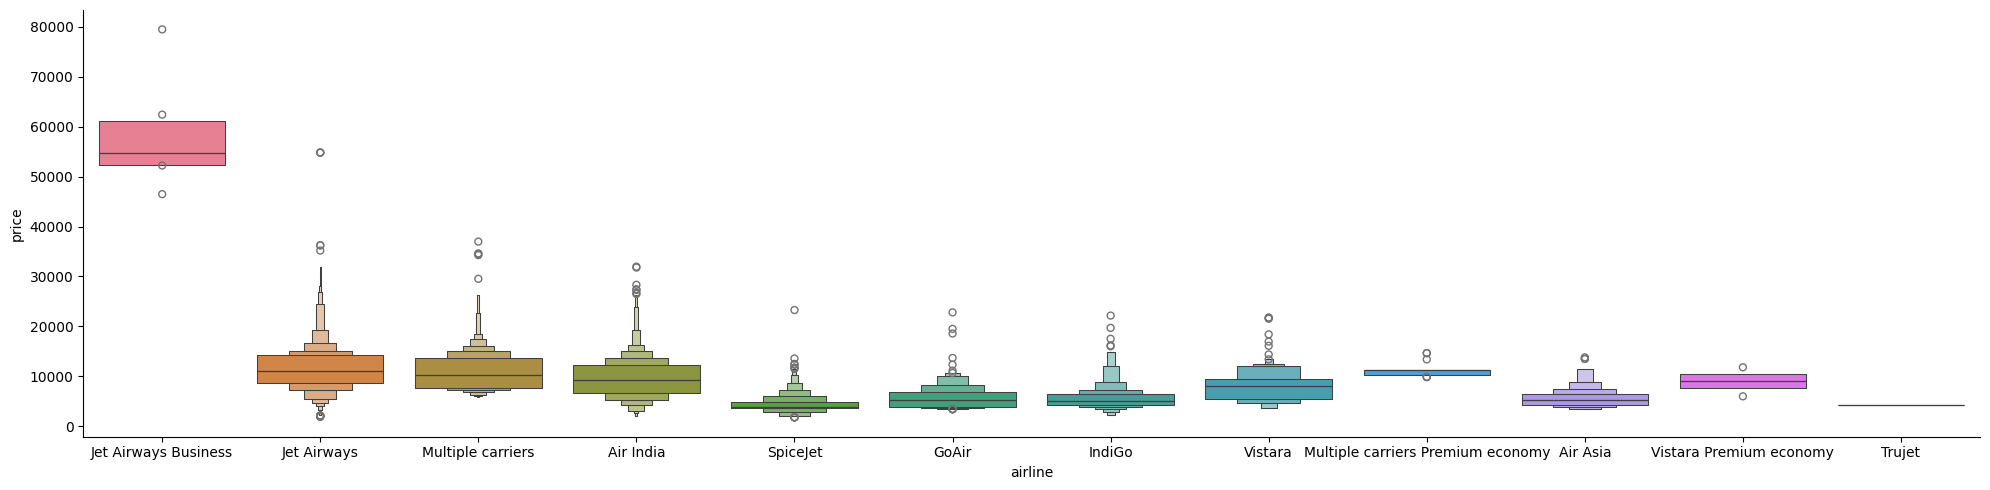

In [14]:
# we can observe that jet airways bussiness is costliest airways
sns.catplot(x="airline",y="price",data=df.sort_values("price",ascending=False),hue="airline", kind="boxen", aspect=4,height=5)

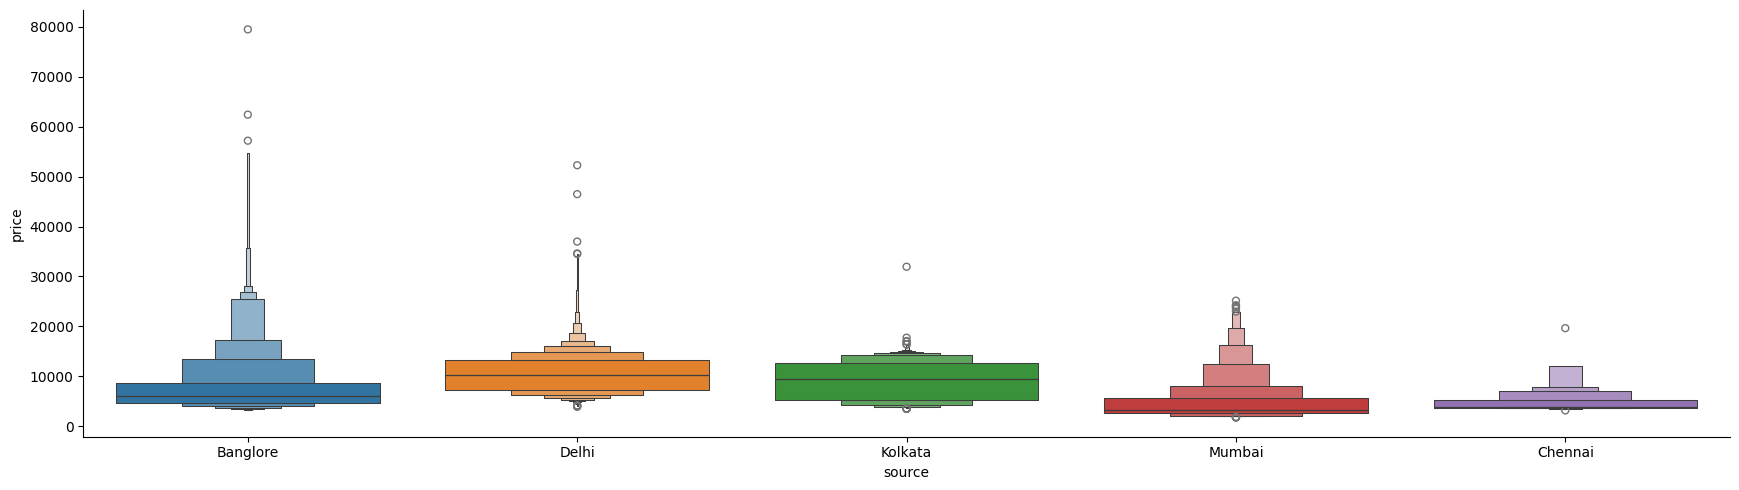

In [15]:
# If we are going from Banglore the prices are slightly higher as compared to other cities
sns.catplot(x="source",y="price",data=df.sort_values("price",ascending=False),hue="source", kind="boxen",aspect=3.5,height=5)

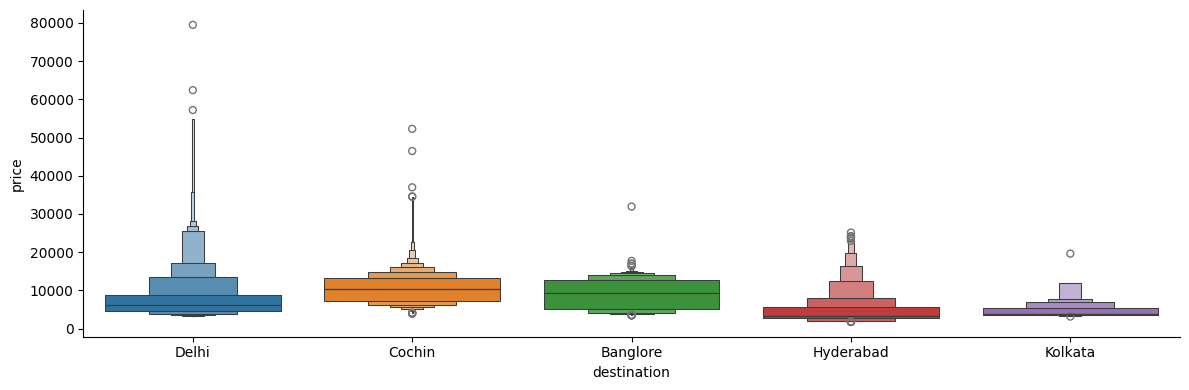

In [16]:
# If we are going to New Delhi the prices are slightly higher as compared to other cities
sns.catplot(x="destination",y="price",data=df.sort_values("price",ascending=False),hue="destination",  kind="boxen",aspect=3,height=4)

In [17]:
#one-hot-encoding for norminal data
df = pd.get_dummies(data=df, columns=["airline", "source", "destination"], drop_first=True)
df[df.select_dtypes("bool").columns] = df.select_dtypes("bool").astype(int)

In [18]:
#label encoding for ordinal data

df["total_stops"] = df["total_stops"].map({"non-stop":0, "1 stop":1, "2 stops":2, "3 stops":3, "4 stops":4})

In [19]:
# drop the unwanted columns
df.drop(["route","additional_info"],inplace=True,axis=1)

In [20]:
df.head()

,total_stops,price,journey_day,journey_month,dep_hour,dep_minute,arrival_hour,arrival_minute,duration_hours,duration_minute,...,airline_Vistara,airline_Vistara Premium economy,source_Chennai,source_Delhi,source_Kolkata,source_Mumbai,destination_Cochin,destination_Delhi,destination_Hyderabad,destination_Kolkata
0,0,3897,24,3,22,20,1,10,2,50,...,0,0,0,0,0,0,0,1,0,0
1,2,7662,1,5,5,50,13,15,7,25,...,0,0,0,0,1,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,...,0,0,0,1,0,0,1,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,...,0,0,0,0,1,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,...,0,0,0,0,0,0,0,1,0,0


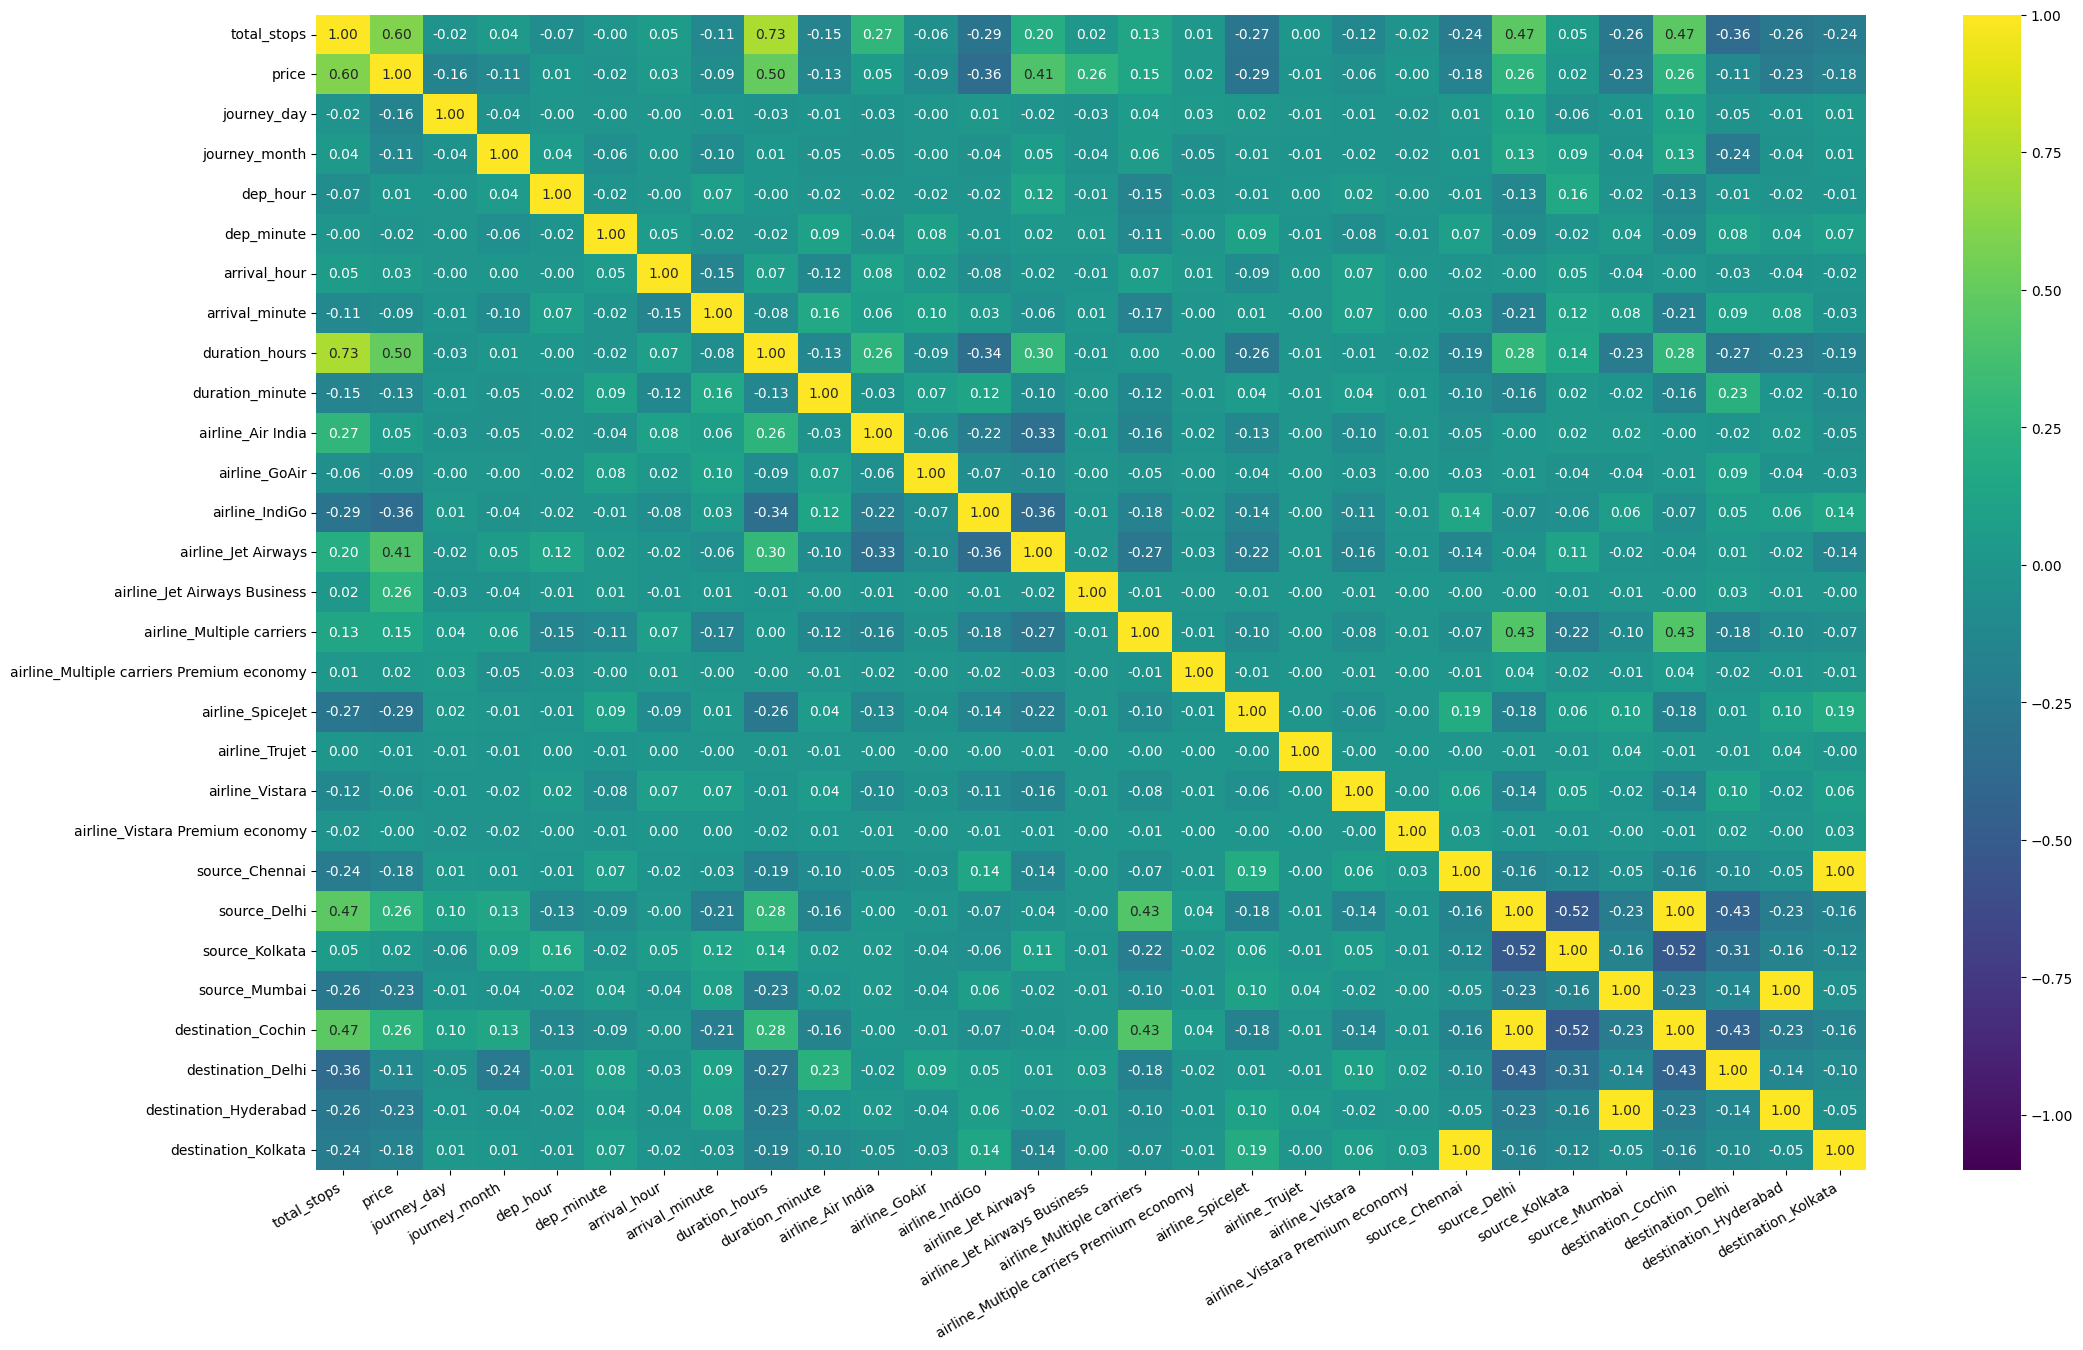

In [21]:
plt.figure(figsize=(25, 15))
sns.heatmap(df.corr(), annot=True, cmap="viridis", fmt=".2f", vmin=1, vmax=-1)

plt.xticks(rotation=30, ha="right")
plt.yticks(rotation=0)
plt.show()

In [22]:
x = df.drop("price",axis=1)
y = df["price"]

In [23]:
reg = ExtraTreesRegressor()
reg.fit(x,y)
reg.feature_importances_

array([2.32291657e-01, 1.43427385e-01, 5.84375840e-02, 2.41806283e-02,
       2.11694445e-02, 2.71094455e-02, 1.97836909e-02, 1.32255038e-01,
       1.80269563e-02, 1.03393755e-02, 1.75430527e-03, 1.56177964e-02,
       1.33294047e-01, 6.85155952e-02, 2.08569269e-02, 9.25244230e-04,
       4.92652600e-03, 8.88404706e-05, 4.40921111e-03, 6.51774366e-05,
       6.71311327e-04, 1.04459508e-02, 5.23787597e-03, 7.73540984e-03,
       1.04424737e-02, 1.92672185e-02, 7.92680314e-03, 7.98080612e-04])

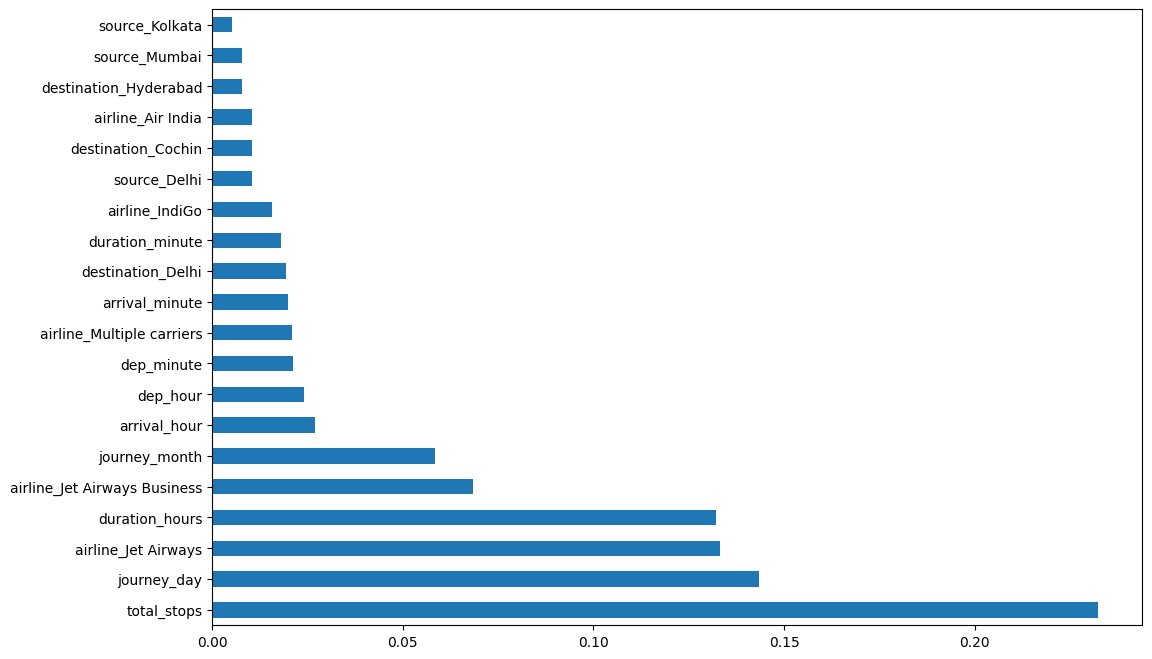

In [24]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(reg.feature_importances_, index=x.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [25]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [45]:
model = XGBRegressor()

In [46]:
model.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [47]:
y_pred = model.predict(x_test)

In [48]:
mean_absolute_error(y_test,y_pred)

1148.512939453125

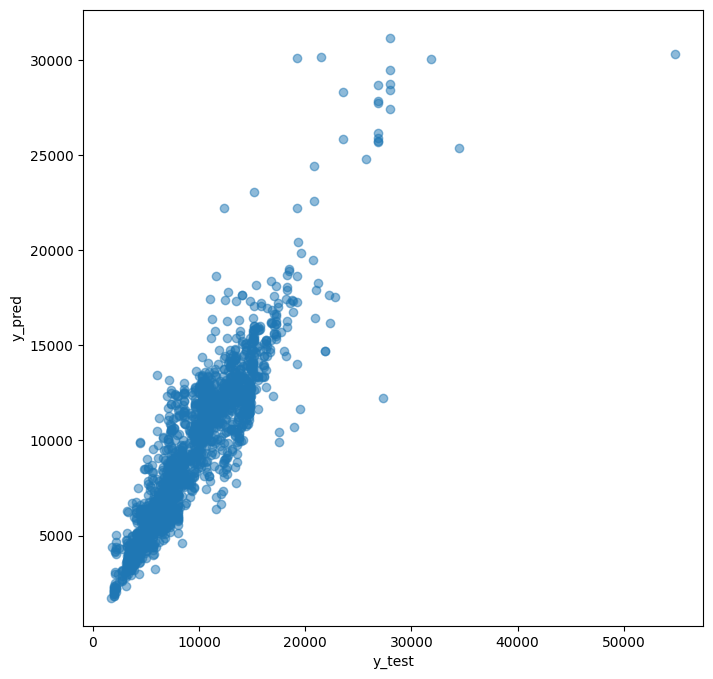

In [50]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [51]:
mean_absolute_error(y_test,y_pred)

1148.512939453125

In [52]:
mean_squared_error(y_test,y_pred)

3169873.75

In [53]:
np.sqrt(mean_squared_error(y_test,y_pred))

np.float64(1780.4139265912295)

In [54]:
r2_score(y_test,y_pred)

0.8467680811882019